In [49]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import matplotlib.pyplot as plt


### Defining Neural Network and Actor-Critic Algorithm

In [50]:
max_num_episode = 500

class ActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):

        super(ActorCritic, self).__init__()

        self.fc = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(),)
        self.actor = nn.Linear(128, n_actions)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc(x)
        return self.actor(x), self.critic(x)

def worker(global_model, optimizer, env_name, n_steps, gamma, global_episode, lock, rewards_list):

    env = gym.make(env_name)

    local_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
    local_model.load_state_dict(global_model.state_dict())

    state, _ = env.reset()
    done = False
    total_reward = 0

    while global_episode.value < max_num_episode:  # limit training episodes

        log_probs, values, rewards = [], [], []

        for _ in range(n_steps):

            state_tensor = torch.from_numpy(state).float()

            logits, value = local_model(state_tensor)

            probs = torch.softmax(logits, dim=-1)

            m = Categorical(probs)

            action = m.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            total_reward += reward

            log_probs.append(m.log_prob(action))
            values.append(value)
            rewards.append(reward)

            state = next_state

            if done:

                state, _ = env.reset()

                with lock:

                    global_episode.value += 1
                    rewards_list.append(total_reward)

                total_reward = 0

                break

        R = torch.zeros(1, 1)
        if not done:

            _, value = local_model(torch.from_numpy(state).float())
            R = value.detach()

        returns = []
        for r in rewards[::-1]:

            R = r + gamma * R

            returns.insert(0, R)

        returns = torch.cat(returns)
        values = torch.cat(values)

        advantage = returns - values

        policy_loss = -(torch.stack(log_probs) * advantage.detach()).mean()

        value_loss = advantage.pow(2).mean()

        optimizer.zero_grad()

        (policy_loss + value_loss).backward()

        for local_param, global_param in zip(local_model.parameters(), global_model.parameters()):

            global_param._grad = local_param.grad

        optimizer.step()
        local_model.load_state_dict(global_model.state_dict())

### Training Model

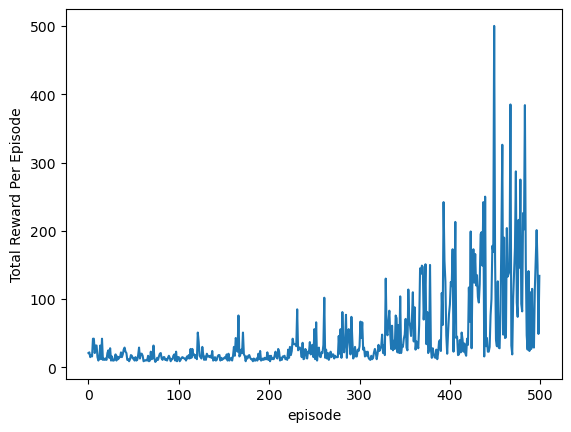

In [51]:
env_name = 'CartPole-v1'
learning_rate = 1e-3  # TODO
processes = []
global_episode = mp.Value('i', 0)
lock = mp.Lock()
manager = mp.Manager()
rewards_list = manager.list()
num_workers = 2  # TODO

input_dim = gym.make(env_name).observation_space.shape[0]
n_actions = gym.make(env_name).action_space.n

global_model = ActorCritic(input_dim, n_actions)
global_model.share_memory()

optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)

for rank in range(num_workers):

    p = mp.Process(target=worker, args=(global_model, optimizer, env_name, 5, 0.99, global_episode, lock, rewards_list))
    
    p.start()
    processes.append(p)

for p in processes:
    p.join()

plt.plot(rewards_list)
plt.xlabel('episode')
plt.ylabel('Total Reward Per Episode')
plt.show()



### Test Model

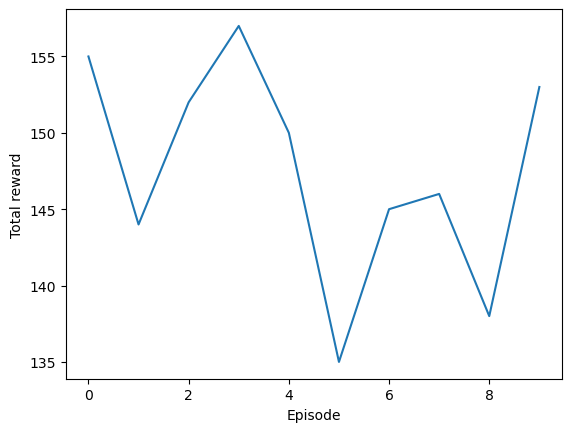

In [52]:
env = gym.make(env_name)
total_rewards = []
num_episodes = 10  # TODO

for episode in range(num_episodes):

    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:

        state_tensor = torch.from_numpy(state).float()

        logits, _ = global_model(state_tensor)

        action = torch.argmax(logits).item()

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        done = terminated or truncated

    total_rewards.append(total_reward)

plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()